In [1]:
import numpy as np
import qibo
from boostvqe.models.dbi.group_commutator_iteration_transpiler import DoubleBracketRotationType

In [2]:
from boostvqe.utils import *
gci = initialize_gci_from_vqe()
print_vqe_comparison_report(gci)

[Qibo 0.2.9|INFO|2024-06-21 11:26:35]: Using numpy backend on /CPU:0
[Qibo 0.2.9|INFO|2024-06-21 11:26:35]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


In the VQE numpy
VQE energy is -14.8569 and the DBQA yields -14.8569. 
The target energy is -15.27613 which means the difference is for VQE 0.41923 and of the DBQA 0.41923 which can be compared to the spectral gap 1.08767.
The relative difference is for VQE 2.74436% and for DBQA 2.74436%.The energetic fidelity witness for the ground state for the
VQE is 0.61456 
and DBQA 0.61456
The true fidelity is 0.00082 
and DBQA 0.61456


In [3]:
def get_gd_evolution_oracle(n_local, params):
    if n_local == 1:
        return MagneticFieldEvolutionOracle(params)
    elif n_local == 2:
        return IsingNNEvolutionOracle(params[:int(len(params)/2)], params[int(len(params)/2):])
    else:
        raise_error(ValueError, "Model not supported, change `n_local` to values in [1, 2]")
     
def gradient_numerical(
    loss_function,
    n_local,
    params: list, 
    loss_0,
    s_0,
    delta: float = 1e-3,
):
    grad = np.zeros(len(params))
    for i in range(len(params)):
        params_new = deepcopy(params)
        params_new[i] += delta
        eo_d = get_gd_evolution_oracle(n_local, params_new)
        # find the increment of a very small step
        grad[i] = (loss_function(s_0, eo_d) - loss_0 ) / delta
        
    # normalize gradient
    grad = grad / max(abs(grad))
    return grad

def adaptive_binary_search(loss_func, threshold=1e-4, a=0, b=2, max_eval=10):
    evaluated_points = {}
    eval_count = {}
    delta_loss = float('inf')

    def eval_func_at_points(eval_points):
        for point in eval_points:
            if point in evaluated_points.keys():
                val = evaluated_points[point]
            else:
                val = loss_func(point)
                evaluated_points[point] = val
        eval_count['eval_count'] = len(evaluated_points.values())
    
    grid = (b-a)/2
    eval_points = [a, a+grid, b]
    eval_func_at_points(eval_points)
    
    while True:
        eval_vals = list(evaluated_points.values())
        eval_grid = list(evaluated_points.keys())
        loss_0 = min(eval_vals)
        ind_min_val =  np.argmin(eval_vals)
        
        if eval_grid[ind_min_val] == min(eval_grid):
            a = a - grid     
            eval_func_at_points([a])
        elif eval_grid[ind_min_val] == max(eval_grid):
            b = b + grid
            eval_func_at_points([b])
        else:
            break

    while True:
        eval_vals = list(evaluated_points.values())
        eval_grid = list(evaluated_points.keys())
        loss_0 = min(eval_vals)
        ind_min_val =  np.argmin(eval_vals)


        delta_loss = min([abs(loss_0 - v) for i,v in enumerate(eval_vals) if i != ind_min_val])  
        if eval_count["eval_count"] > max_eval:
            exit_criterion = "max_evals"
            break
        if delta_loss < threshold: 
            exit_criterion = "tolerance achieved"
            break
        
        grid /=2
        eval_points = [eval_grid[ind_min_val]-grid, eval_grid[ind_min_val]+grid]
        eval_func_at_points(eval_points)
    return eval_grid[ind_min_val], loss_0, evaluated_points

In [4]:
def choose_gd_params(gci,
                     n_local,
                     params,
                     loss_0,
                     s_0,
                     s_min=1e-4,
                     s_max=2e-2,
                     lr_min=1e-4,
                     lr_max=1,
                     threshold=1e-4,
                     max_eval=30,
                     ):
    evaluated_points = {}
    max_eval = int(np.sqrt(max_eval))
    grad = gradient_numerical(gci.loss, n_local, params, loss_0, s_0)

    def loss_func_lr(lr):
        filtered_entries = {k:v for k, v in evaluated_points.items() if k[0]==lr}
        if len(filtered_entries) > 0:
            return min(filtered_entries.values())
        elif lr < 0:
            return 0
        else:
            params_eval = (1 - grad*lr) * deepcopy(params)
            eo_d = get_gd_evolution_oracle(n_local, params_eval)
            # given lr find best possible s_min and loss_min
            best_s, best_loss, evaluated_points_s = adaptive_binary_search(lambda s: gci.loss(s, eo_d) if s>0 else 0, threshold, s_min, s_max, max_eval)
            for s,l in evaluated_points_s.items():
                if l < 0:
                    evaluated_points[(lr, s)] = l
        return best_loss
    
    best_lr, best_loss, _ = adaptive_binary_search(loss_func_lr, threshold, lr_min, lr_max, max_eval)
    eo_d = get_gd_evolution_oracle(n_local, (1-grad*lr_min)*params)
    # find best_s
    for (lr, s), loss in evaluated_points.items():
        if lr == best_lr and loss == best_loss:
            best_s = s
    return eo_d, best_s, best_loss, evaluated_points
    

In [5]:
from mpl_toolkits.mplot3d import Axes3D
def plot_lr_s_loss(eval_dict):
    lr = [key[0] for key in eval_dict.keys()]
    s = [key[1] for key in eval_dict.keys()]
    loss = [value for value in eval_dict.values()]
    min_loss_index = loss.index(min(loss))
    min_lr = lr[min_loss_index]
    min_s = s[min_loss_index]
    min_loss = loss[min_loss_index]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(lr, s, loss, c=loss, cmap='viridis')
    ax.scatter([min_lr], [min_s], [min_loss], color='red', s=100, label='Minimum Loss')
    ax.text(min_lr, min_s, min_loss, f'({np.round(min_lr,2)}, {np.round(min_s,2)}, {np.round(min_loss,4)})', color='red')
    colorbar = plt.colorbar(sc)
    colorbar.set_label('Loss')
    ax.set_xlabel('Learning Rate (lr)')
    ax.set_ylabel('Step (s)')
    ax.set_zlabel('Loss')
    ax.legend()
    ax.set_title('3D Scatter Plot of (lr, s): loss')

In [6]:
def select_recursion_step_gd_circuit(gci, 
                    mode_dbr_list = [DoubleBracketRotationType.group_commutator_third_order], 
                    eo_d = None,
                    step_grid = np.linspace(1e-3,3e-2,10),
                    lr_range = (1e-3, 1),
                    use_gd = False,
                    threshold = 1e-4,
                    max_eval_gd = 30,
                    please_be_visual = False):
    """ Returns: circuit of the step, code of the strategy"""

    if eo_d is None:
        eo_d = gci.eo_d    
    if eo_d.name == "B Field":
        n_local = 1
        params = eo_d.b_list
    elif eo_d.name == "H_ClassicalIsing(B,J)":
        n_local = 2
        params = eo_d.b_list + eo_d.j_list
    else:
        raise_error(ValueError, "Evolution oracle type not supported.")
        
    minimal_losses = []
    minimizer_s = []
    minimizer_eo_d = []
    for i,mode in enumerate(mode_dbr_list):

        gci.mode_double_bracket_rotation = mode
        # returns min_s, min_loss, loss_list
        s, l, ls = gci.choose_step(d = eo_d,step_grid = step_grid, mode_dbr = mode)
        step_grid
        if use_gd:
            ls = []
            s_min, s_max = step_grid[0], step_grid[-1]
            lr_min, lr_max = lr_range[0], lr_range[-1]
            eo_d, s, l, eval_dict = choose_gd_params(gci, n_local, params, l, s, s_min, s_max, lr_min, lr_max, threshold, max_eval_gd)
                
        minimal_losses.append(l)
        minimizer_s.append(s)
        minimizer_eo_d.append(eo_d)
        
        if please_be_visual:
            if not use_gd:
                plt.plot(step_grid, ls)
                plt.yticks([ls[0],l, ls[-1]])
                plt.xticks([step_grid[0],s,step_grid[-1]])
                plt.show()
            else:
                plot_lr_s_loss(eval_dict)
                plt.show()
            
    minimizer_dbr_id = np.argmin(minimal_losses)
    
    return mode_dbr_list[minimizer_dbr_id], minimizer_s[minimizer_dbr_id], minimizer_eo_d[minimizer_dbr_id]

In [7]:
b_list = [1+np.sin(x/3)for x in range(10)]
eo_d_m_field = MagneticFieldEvolutionOracle(b_list)
eo_d_nn = IsingNNEvolutionOracle(b_list, b_list)

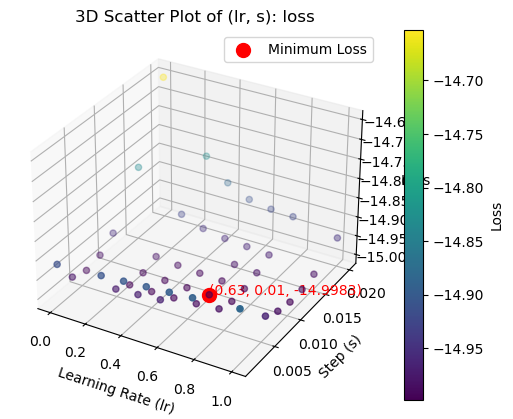

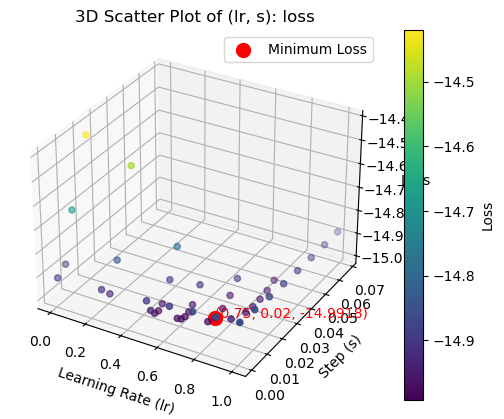

In [8]:
mode_dbr, minimizer_s, eo_d = select_recursion_step_gd_circuit(
    gci, mode_dbr_list = [DoubleBracketRotationType.group_commutator_third_order_reduced, 
                          DoubleBracketRotationType.group_commutator],
    eo_d = eo_d_nn,
    use_gd = True,
    step_grid = np.linspace(1e-3,2e-2,10),
    please_be_visual = True)
